# Training an Image Classification Model in R via CNTK
<img src="http://karpathy.github.io/assets/cifar_preview.png" width="300px" align="left"/>

In [1]:
library(devtools)
load_all()
library(cntk)
library(magrittr)

Loading cntk


In [2]:
create_reader <- function(path, is_training, input_dim, label_dim) {
    MinibatchSource(CTFDeserializer(path, sd <- StreamDefs(
        features = StreamDef(field = "features", shape = input_dim),
        labels = StreamDef(field = "labels", shape = label_dim)
    )), randomize = is_training, max_sweeps = ifelse(is_training, 23L, 1L))
}

### Setup & Architecture

In [3]:
data_path <- file.path("..", "..", "Examples", "Image", "DataSets", "CIFAR-10")
epoch_size <- 200
minibatch_size <- 64
max_epochs <- 1
image_height <- 32
image_width <- 32
num_channels <- 32
input_dim <- image_height * image_width * num_channels
num_output_classes <- 10

Create the input variables denoting features and label data. Data type is automatically set to np.float32.

In [4]:
input_var <- input_variable(c(num_channels, image_height, image_width), name="input")
label_var <- input_variable(num_output_classes, name="label")

Normalize inputs and define model architecture

In [5]:
input_remove_mean <- minus(input_var, constant(128))
normalized_input <- element_times(constant(0.00390625), input_remove_mean)

In [6]:
z <- Sequential(
    For(1:2, function() { 
        c(
            Convolution2D(c(3, 3), 64, relu, pad = TRUE),
            Convolution2D(c(3, 3), 64, relu, pad = TRUE),
            MaxPooling(c(3, 3), c(2, 2), pad = TRUE)
        )
    }),
    Dense(256, relu),
    Dropout(0.5),
    Dense(128, relu),
    Dropout(0.5),
    Dense(num_output_classes, activation = NULL)
)(normalized_input)

### Training
Define cross entropy as loss function, classification error as evaluation metric

In [7]:
loss <- cross_entropy_with_softmax(z, label_var)
metric <- classification_error(z, label_var)

In [8]:
reader_train <- create_reader(file.path(data_path, 'Train_cntk_text.txt'), 
                              TRUE, input_dim, num_output_classes)

Set learning rate and momentum schedules, use SGD as learner

In [9]:
lr_per_sample <- c(rep(c(0.0015625), 10), rep(c(0.00046875), 10), 0.00015625)
lr_schedule <- learning_rate_schedule(0.001, UnitType$sample, epoch_size)
mm_time_constant <- c(rep(0, 20), -minibatch_size / log(0.9))
mm_schedule <- momentum_as_time_constant_schedule(mm_time_constant, epoch_size)
l2_reg_weight <- 0.002

In [10]:
learner <- momentum_sgd(z$parameters, lr_schedule, mm_schedule,
                       l2_regularization_weight = l2_reg_weight)
progress_printer <- ProgressPrinter(tag = 'Training', num_epochs = max_epochs)
trainer <- Trainer(z, c(loss, metric), learner, progress_printer)

Creating mapping from features to data

In [11]:
input_map = mapping(
    "input" = reader_train$streams$features,
    "label" = reader_train$streams$labels
)

Update weights on training data across some number of epochs

In [12]:
loss_over_time <- c()
for (epoch in 1:max_epochs) {
    sample_count <- 0
    while (sample_count < epoch_size) {
        current_minibatch <- min(minibatch_size, epoch_size - sample_count)
        data <- reader_train %>% next_minibatch(current_minibatch, input_map = input_map)
        result <- trainer %>% test_minibatch(data)
        loss_over_time <- c(loss_over_time, result)
        trainer %>% train_minibatch(data)
        sample_count <- sample_count + trainer$previous_minibatch_sample_count
    }
}

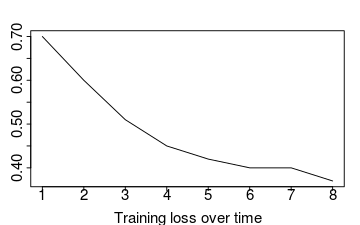

In [24]:
library(repr)
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res=90, repr.plot.pointsize=5)
plot(loss_over_time, type="l", xlab='', ylab='', sub="Training loss over time")

### Evaluation

In [14]:
reader_test <- create_reader(file.path(data_path, 'Test_cntk_text.txt'), FALSE,
                            input_dim, num_output_classes)

Redefine mapping to test data

In [15]:
input_map <- mapping(
    "input" = reader_test$streams$features,
    "label" = reader_test$streams$labels
)

In [16]:
epoch_size <- 2000
minibatch_size <- 200
metric_numer <- 0
metric_denom <- 0
sample_count <- 0
minibatch_index <- 0

Evaluate model on test set

In [17]:
while (sample_count < epoch_size) {
    current_minibatch <- min(minibatch_size, epoch_size - sample_count)
    data <- reader_test %>% next_minibatch(current_minibatch, input_map = input_map)
    metric_numer = metric_numer + trainer %>% test_minibatch(data) * current_minibatch
    metric_denom = metric_denom + current_minibatch
    sample_count = sample_count + data$label$num_samples
    minibatch_index = minibatch_index + 1
}

In [25]:
sprintf("Final error: %g%%", metric_numer / metric_denom * 100)

[1] "Final error: 35%"